In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [14]:
from catboost import CatBoostRegressor
from sklearn.linear_model import BayesianRidge, OrthogonalMatchingPursuit
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [13]:
# Load the datasets
train_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [18]:
train_df.size

118260

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


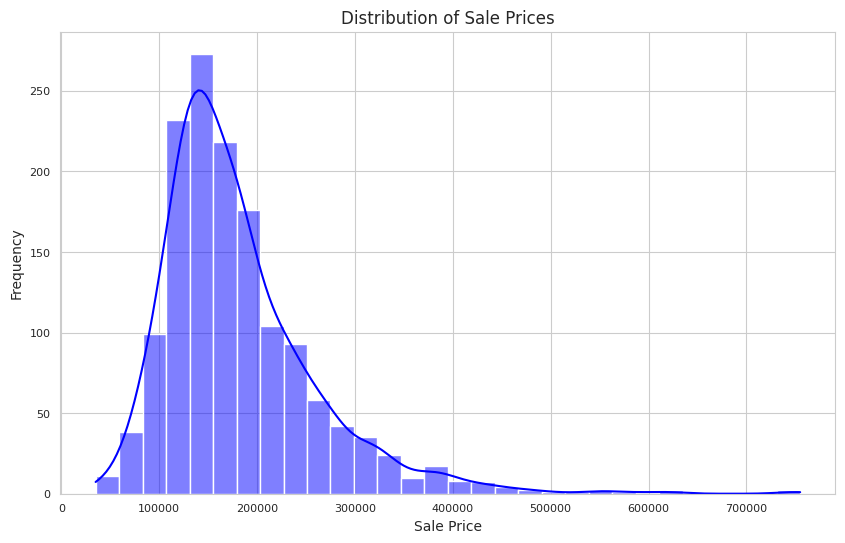

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Distribution of Sale Prices
plt.figure(figsize=(10, 6))
sns.histplot(train_df['SalePrice'], kde=True, bins=30, color='blue')
plt.title('Distribution of Sale Prices')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.show()

In [22]:
# Separate target variable and predictors
X_train = train_df.drop(['Id', 'SalePrice'], axis=1)
y_train = np.log(train_df['SalePrice'])  # Transform target variable with logarithm
X_test = test_df.drop(['Id'], axis=1)

In [22]:
# Identify numerical and categorical columns
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

In [31]:

models = {
    "TreeBased": {
        "RandomForest": RandomForestRegressor(),
        "ExtraTrees": ExtraTreesRegressor()
    },
    "Boosting": {
        "XGBoost": XGBRegressor(),
        "LightGBM": LGBMRegressor(),
        "CatBoost": CatBoostRegressor(silent=True)
    }
}

# Define grid search parameters for each model type
param_grids = {
    "TreeBased": {
        "RandomForest": {
            "model__n_estimators": [100, 200],
            "model__max_depth": [None, 5],
            "model__min_samples_split": [2, 5]
        },
        "ExtraTrees": {
            "model__n_estimators": [100, 200],
            "model__max_depth": [None, 5],
            "model__min_samples_split": [2, 5]
        }
    },
    "Boosting": {
        "XGBoost": {
            "model__n_estimators": [100, 200],
            "model__max_depth": [3, 5],
            "model__learning_rate": [0.05, 0.1]
        },
       "LightGBM": {
            "model__n_estimators": [100, 200],
            "model__verbosity": [0], 
            "model__max_depth": [3, 5]
            # You can adjust other parameters here, but leave out learning_rate
        },
        "CatBoost": {}
    }
}



# Grid search for the best model
best_score = -np.inf
best_model_name = None
best_params = None

for model_type, model_dict in models.items():
    for model_name, model in model_dict.items():
        # Create pipeline with preprocessor and current model
        pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('model', model)])
        
        # Perform grid search for the current model
        grid_search = GridSearchCV(pipeline, param_grid=param_grids[model_type][model_name], cv=3, scoring='neg_mean_squared_error')
        grid_search.fit(X_train, y_train)
        
        # Check if current model has better score than previous best
        if grid_search.best_score_ > best_score:
            best_score = grid_search.best_score_
            best_model_name = model_name
            best_params = grid_search.best_params_

# Reconstruct the best model pipeline
best_model = models["TreeBased"].get(best_model_name, None) or models["Boosting"].get(best_model_name, None)
if best_model:
    best_model.set_params(**best_params)
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', best_model)])

# Train the best model
pipeline.fit(X_train, y_train)

# Print best model and parameters
print("Best model:", best_model_name)
print("Best parameters:", best_params)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [32]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrL...
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object'))])),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x7fcc842fcbe0>)])

In [34]:
predictions_log_scale = pipeline.predict(X_test)

# Convert predictions back from log scale
predictions = np.exp(predictions_log_scale)

# Create a DataFrame for the predictions
predictions_df = pd.DataFrame({
    'Id': test_df['Id'],
    'SalePrice': predictions
})

predictions_df.head()

,Id,SalePrice
0,1461,125405.248327
1,1462,160856.413471
2,1463,182019.632014
3,1464,190022.442985
4,1465,186303.892232


In [35]:
predictions_df.to_csv("submission.csv", index=False)